## Import

In [1]:
import pickle
import matplotlib.pyplot as plt
import warnings

from config import CONFIG
from easydict import EasyDict

from env.env import *
from state.state import *
from agent.PPOAgent_ms import *
from models.CTTS import *
from trainer.nonEpisodic import *
from utils.setDevice import *
from utils.timestepRelated import *
from visualization.methods import *

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Load

In [3]:
with open('../data/processed/kospi200_ffill_clean_version.pkl', 'rb') as f:
    df = pickle.load(f)

df.head(5)

,date,time,open,high,low,close,prevClose,vol
2010-02-16 09:01:00,20100216,901,207.55,207.65,207.50,207.60,207.5,3985.0
2010-02-16 09:02:00,20100216,902,207.60,207.65,207.25,207.55,207.5,5095.0
2010-02-16 09:03:00,20100216,903,207.55,207.80,207.50,207.60,207.5,2175.0
2010-02-16 09:04:00,20100216,904,207.55,207.85,207.55,207.80,207.5,1301.0
2010-02-16 09:05:00,20100216,905,207.80,208.15,207.80,208.05,207.5,3870.0


## Set State info • scaler

In [4]:
target_values = ['open', 'high', 'low', 'close', 
                'vol','return_5', 'return_10', 'volume_change', 'ema_5', 
                'ema_20', 'ema_cross', 'cci', 'sar', '%K', 
                # '%D', 'roc', 'rsi', 'obv', 'ad_line', 
                'bb_upper', 'bb_lower', 'bb_width', 'atr', 'gap_size']

scaler = RobustScaler()

## Set Env info 

In [5]:
train_valid_timestep = split_date_ranges_by_group(df.index[:100000])
train_valid_timestep 

[(('2010-02-16', '2010-04-23'), ('2010-04-26', '2010-05-03')),
 (('2010-05-04', '2010-07-13'), ('2010-07-14', '2010-07-22')),
 (('2010-07-23', '2010-10-01'), ('2010-10-04', '2010-10-11')),
 (('2010-10-12', '2010-12-16'), ('2010-12-17', '2010-12-24')),
 (('2010-12-27', '2011-03-15'), ('2011-03-16', '2011-03-23'))]

In [6]:
# 
execution_strength = CONFIG.MAX_CONTRACT 
action_space = list(range(-execution_strength, execution_strength+1))
n_actions = len(action_space)
device = get_device() # torch.device("cpu")  

CONFIG.INPUT_DIM = len(target_values)
CONFIG.REWARD_FTN = reward_unrealized_pnl_diff_log
CONFIG.DONE_FTN = is_day_changed
CONFIG.TRAIN_VALID_TIMESTEP = train_valid_timestep
CONFIG.SCALER = scaler

In [7]:
state =  State(target_values)

model = MultiStatePV(
    input_dim=CONFIG.INPUT_DIM,
    agent_input_dim=CONFIG.AGENT_INPUT_DIM,
    embed_dim=CONFIG.EMBED_DIM,
    kernel_size=CONFIG.KERNEL_SIZE,
    stride=CONFIG.STRIDE,
    action_size=CONFIG.N_ACTIONS,
    device=device,
    agent_hidden_dim=CONFIG.AGENT_HIDDEN_DIM,
    agent_out_dim=CONFIG.AGENT_OUT_DIM,
    fusion_hidden_dim=CONFIG.FUSION_HIDDEN_DIM,
    num_layers=CONFIG.NUM_LAYERS,
    num_heads=CONFIG.NUM_HEADS,
    d_ff=CONFIG.D_FF,
    dropout=CONFIG.DROPOUT
)

agent = PPOAgent(
    action_space=CONFIG.ACTION_SPACE,
    n_actions=CONFIG.N_ACTIONS,
    model=model,
    value_coeff=CONFIG.VALUE_COEFF,
    entropy_coeff=CONFIG.ENTROPY_COEFF,
    clip_eps=CONFIG.CLIP_EPS,
    gamma=CONFIG.GAMMA,
    lr=CONFIG.LR,
    batch_size=CONFIG.BATCH_SIZE,
    epoch=CONFIG.EPOCH,
    device=device
)

== [0] interval training ===========================
Robust Scaling Completed.
Robust Scaling Completed.
>>>> Train : ('2010-02-16', '2010-04-23')
[0|Train] Episode 0 | Loss:  0.2761 | (short : 39 %, hold : 11%, long: 50%) | (Ave) Strength: 216.00 |Reward: -20 | Avg(50): -19.81 | Maintained Len: 100
[0|Train] Episode 1 | Loss:  0.2315 | (short : 46 %, hold : 14%, long: 40%) | (Ave) Strength: 211.50 |Reward: -13 | Avg(50): -16.44 | Maintained Len: 200
[0|Train] Episode 2 | Loss:  0.4047 | (short : 51 %, hold : 14%, long: 35%) | (Ave) Strength: 211.67 |Reward: -26 | Avg(50): -19.50 | Maintained Len: 300
[0|Train] Episode 3 | Loss:  0.2992 | (short : 42 %, hold : 19%, long: 39%) | (Ave) Strength: 206.75 |Reward: -18 | Avg(50): -19.23 | Maintained Len: 400
[0|Train] Episode 4 | Loss:  0.4221 | (short : 37 %, hold : 15%, long: 48%) | (Ave) Strength: 209.60 |Reward: -30 | Avg(50): -21.44 | Maintained Len: 500
[0|Train] Episode 5 | Loss:  0.1269 | (short : 43 %, hold : 22%, long: 35%) | (Ave)

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[0: latest model |Valid] Episode 0 |(short : 46 %, hold : 3%, long: 51%) | (Ave) Strength: 2489.00 |Reward: -78 | Avg(50): -77.91 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 0] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -77.91
  - 평균 유지 시간: nan step
  - 마지막 수익: -42575285.73

[0: highest reward |Valid] Episode 0 |(short : 45 %, hold : 3%, long: 51%) | (Ave) Strength: 2559.00 |Reward: -115 | Avg(50): -115.44 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 0] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -115.44
  - 평균 유지 시간: nan step
  - 마지막 수익: -69777214.53

[0: per steps |Valid] Episode 0 |(short : 42 %, hold : 2%, long: 56%) | (Ave) Strength: 2580.00 |Reward: -100 | Avg(50): -100.41 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 0] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -100.41
  - 평균 유지 시간: nan step
  - 마지막 수익: -104349333.12

✅ 시각화 저장 완료: /Users/ijimin/Documents/GitHub/YOLO-Futures/logs/I0V
[Saved] latest_model
[Saved] reward_king_model
[Saved] 10 recent mo

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[1: latest model |Valid] Episode 0 |(short : 16 %, hold : 2%, long: 82%) | (Ave) Strength: 2995.00 |Reward: -109 | Avg(50): -108.69 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 1] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -108.69
  - 평균 유지 시간: nan step
  - 마지막 수익: -18568344.74

[1: highest reward |Valid] Episode 0 |(short : 17 %, hold : 2%, long: 81%) | (Ave) Strength: 2983.00 |Reward: -111 | Avg(50): -110.55 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 1] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -110.55
  - 평균 유지 시간: nan step
  - 마지막 수익: -15574281.37

[1: per steps |Valid] Episode 0 |(short : 17 %, hold : 2%, long: 81%) | (Ave) Strength: 2954.00 |Reward: -135 | Avg(50): -134.93 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 1] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -134.93
  - 평균 유지 시간: nan step
  - 마지막 수익: -11363643.13

✅ 시각화 저장 완료: /Users/ijimin/Documents/GitHub/YOLO-Futures/logs/I1V
[Saved] latest_model
[Saved] reward_king_model
[Saved] 10 recent 

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2: latest model |Valid] Episode 0 |(short : 21 %, hold : 7%, long: 73%) | (Ave) Strength: 2229.00 |Reward: -110 | Avg(50): -109.58 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 2] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -109.58
  - 평균 유지 시간: nan step
  - 마지막 수익: 15222329.68

[2: highest reward |Valid] Episode 0 |(short : 18 %, hold : 8%, long: 74%) | (Ave) Strength: 2237.00 |Reward: -106 | Avg(50): -105.76 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 2] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -105.76
  - 평균 유지 시간: nan step
  - 마지막 수익: 103758455.70

[2: per steps |Valid] Episode 0 |(short : 20 %, hold : 10%, long: 70%) | (Ave) Strength: 2130.00 |Reward: -126 | Avg(50): -125.92 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 2] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -125.92
  - 평균 유지 시간: nan step
  - 마지막 수익: 118060788.62

✅ 시각화 저장 완료: /Users/ijimin/Documents/GitHub/YOLO-Futures/logs/I2V
[Saved] latest_model
[Saved] reward_king_model
[Saved] 10 recent 

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[3: latest model |Valid] Episode 0 |(short : 10 %, hold : 48%, long: 42%) | (Ave) Strength: 1144.00 |Reward: -83 | Avg(50): -82.74 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 3] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -82.74
  - 평균 유지 시간: nan step
  - 마지막 수익: 7863632.44

[3: highest reward |Valid] Episode 0 |(short : 9 %, hold : 48%, long: 43%) | (Ave) Strength: 1197.00 |Reward: -40 | Avg(50): -40.27 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 3] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -40.27
  - 평균 유지 시간: nan step
  - 마지막 수익: -22066537.84

[3: per steps |Valid] Episode 0 |(short : 9 %, hold : 47%, long: 43%) | (Ave) Strength: 1183.00 |Reward: -73 | Avg(50): -73.29 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 3] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -73.29
  - 평균 유지 시간: nan step
  - 마지막 수익: -13727325.93

✅ 시각화 저장 완료: /Users/ijimin/Documents/GitHub/YOLO-Futures/logs/I3V
[Saved] latest_model
[Saved] reward_king_model
[Saved] 10 recent models
== 

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[4: latest model |Valid] Episode 0 |(short : 7 %, hold : 64%, long: 30%) | (Ave) Strength: 848.00 |Reward: -102 | Avg(50): -101.88 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 4] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -101.88
  - 평균 유지 시간: nan step
  - 마지막 수익: 15632677.91

[4: highest reward |Valid] Episode 0 |(short : 6 %, hold : 65%, long: 30%) | (Ave) Strength: 838.00 |Reward: -100 | Avg(50): -100.13 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 4] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -100.13
  - 평균 유지 시간: nan step
  - 마지막 수익: 27201132.95

[4: per steps |Valid] Episode 0 |(short : 5 %, hold : 62%, long: 32%) | (Ave) Strength: 896.00 |Reward: -66 | Avg(50): -65.73 | Maintained Steps: 1579

== [Valid 결과 요약: Interval 4] ==================
  - 총 에피소드 수: 1
  - 평균 보상: -65.73
  - 평균 유지 시간: nan step
  - 마지막 수익: 21036335.95

✅ 시각화 저장 완료: /Users/ijimin/Documents/GitHub/YOLO-Futures/logs/I4V
[Saved] latest_model
[Saved] reward_king_model
[Saved] 10 recent models


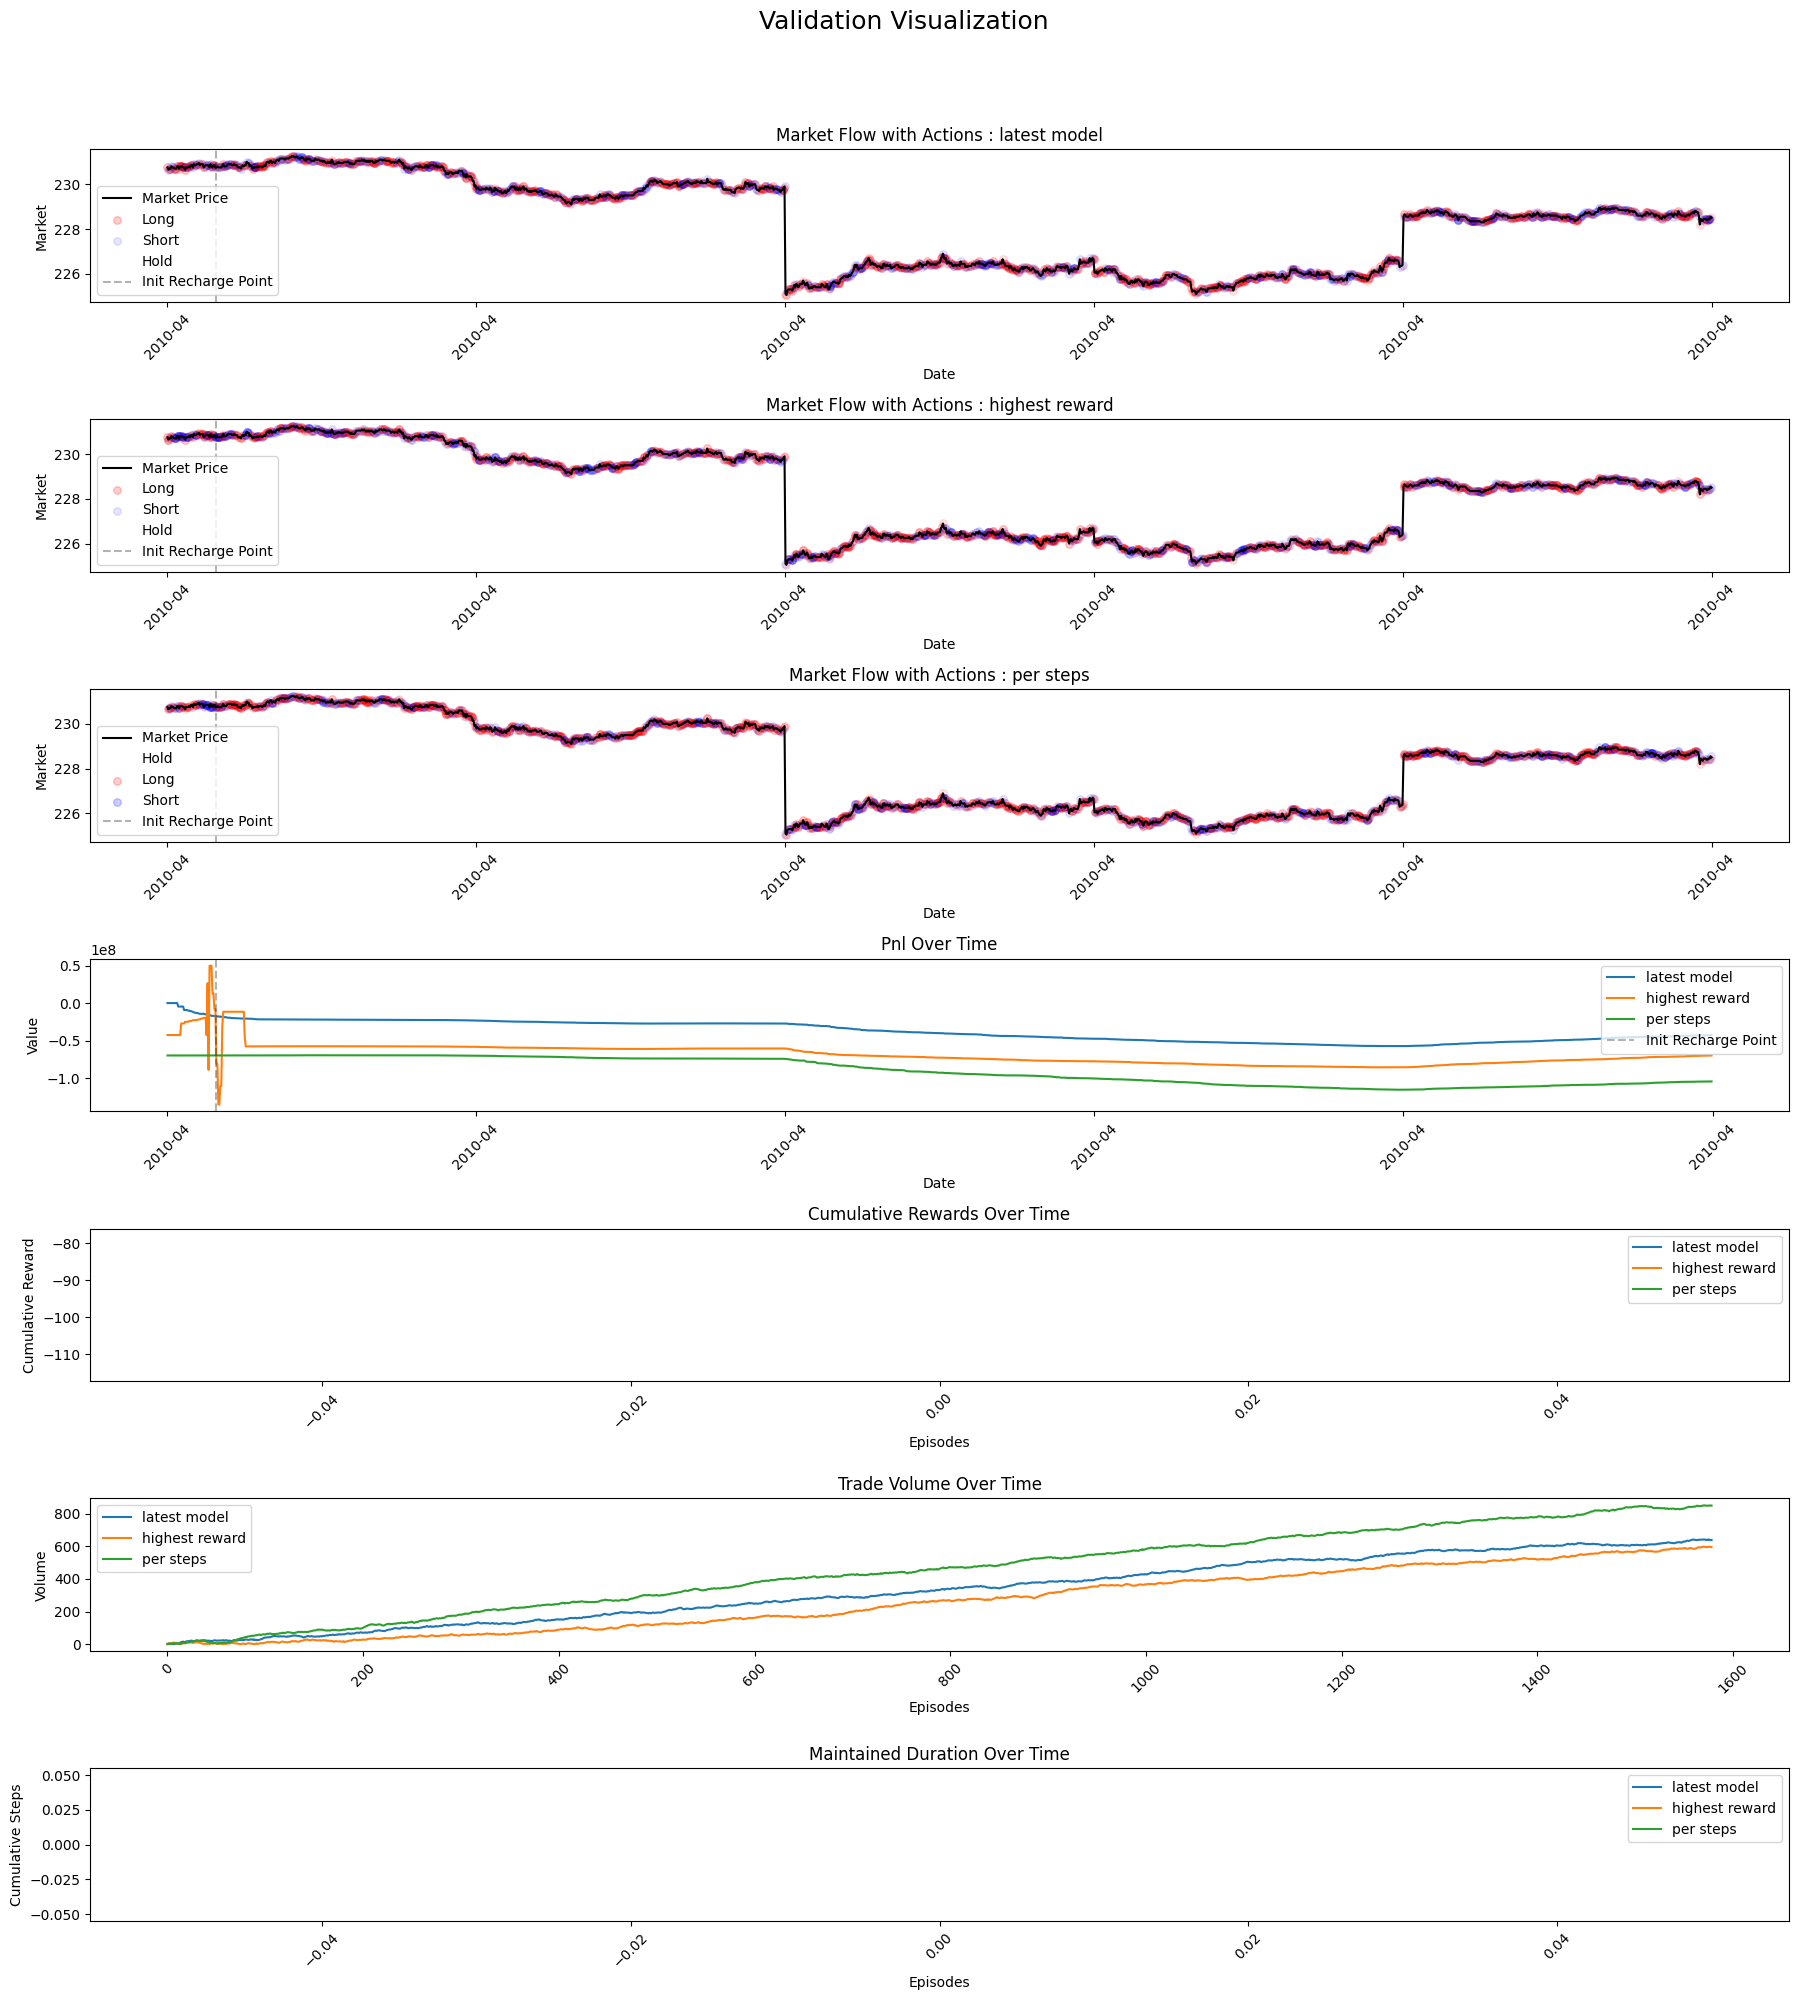

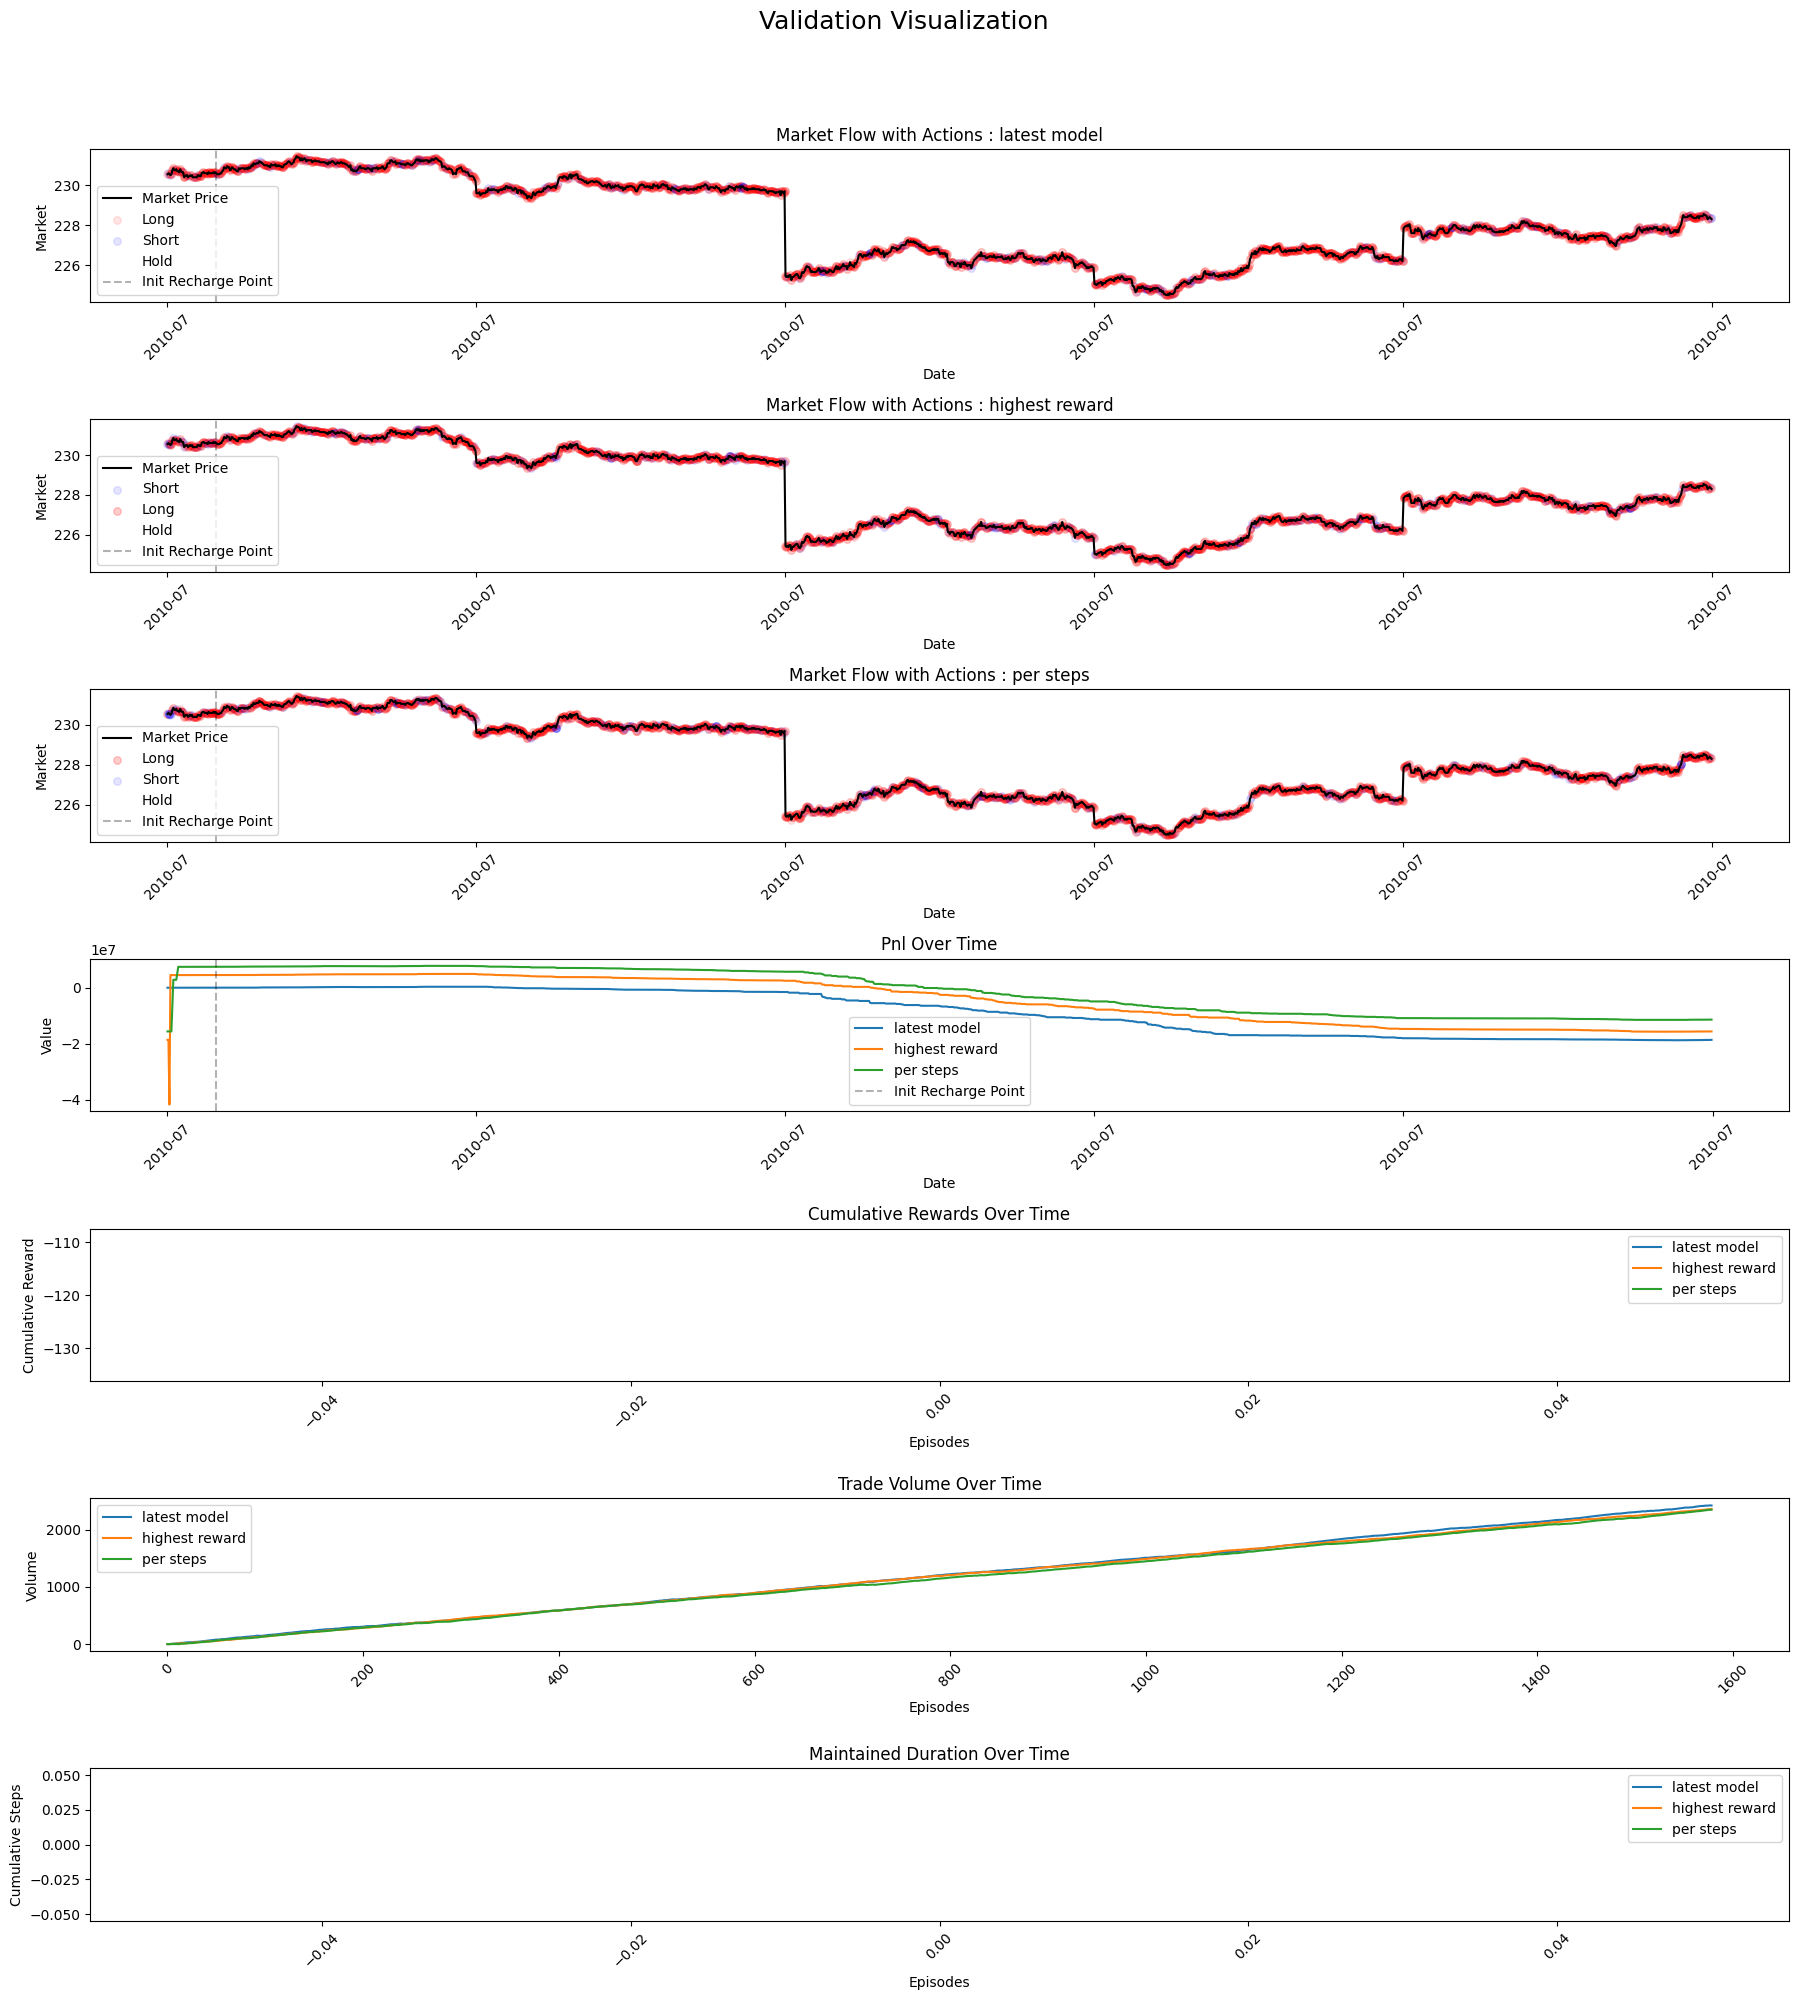

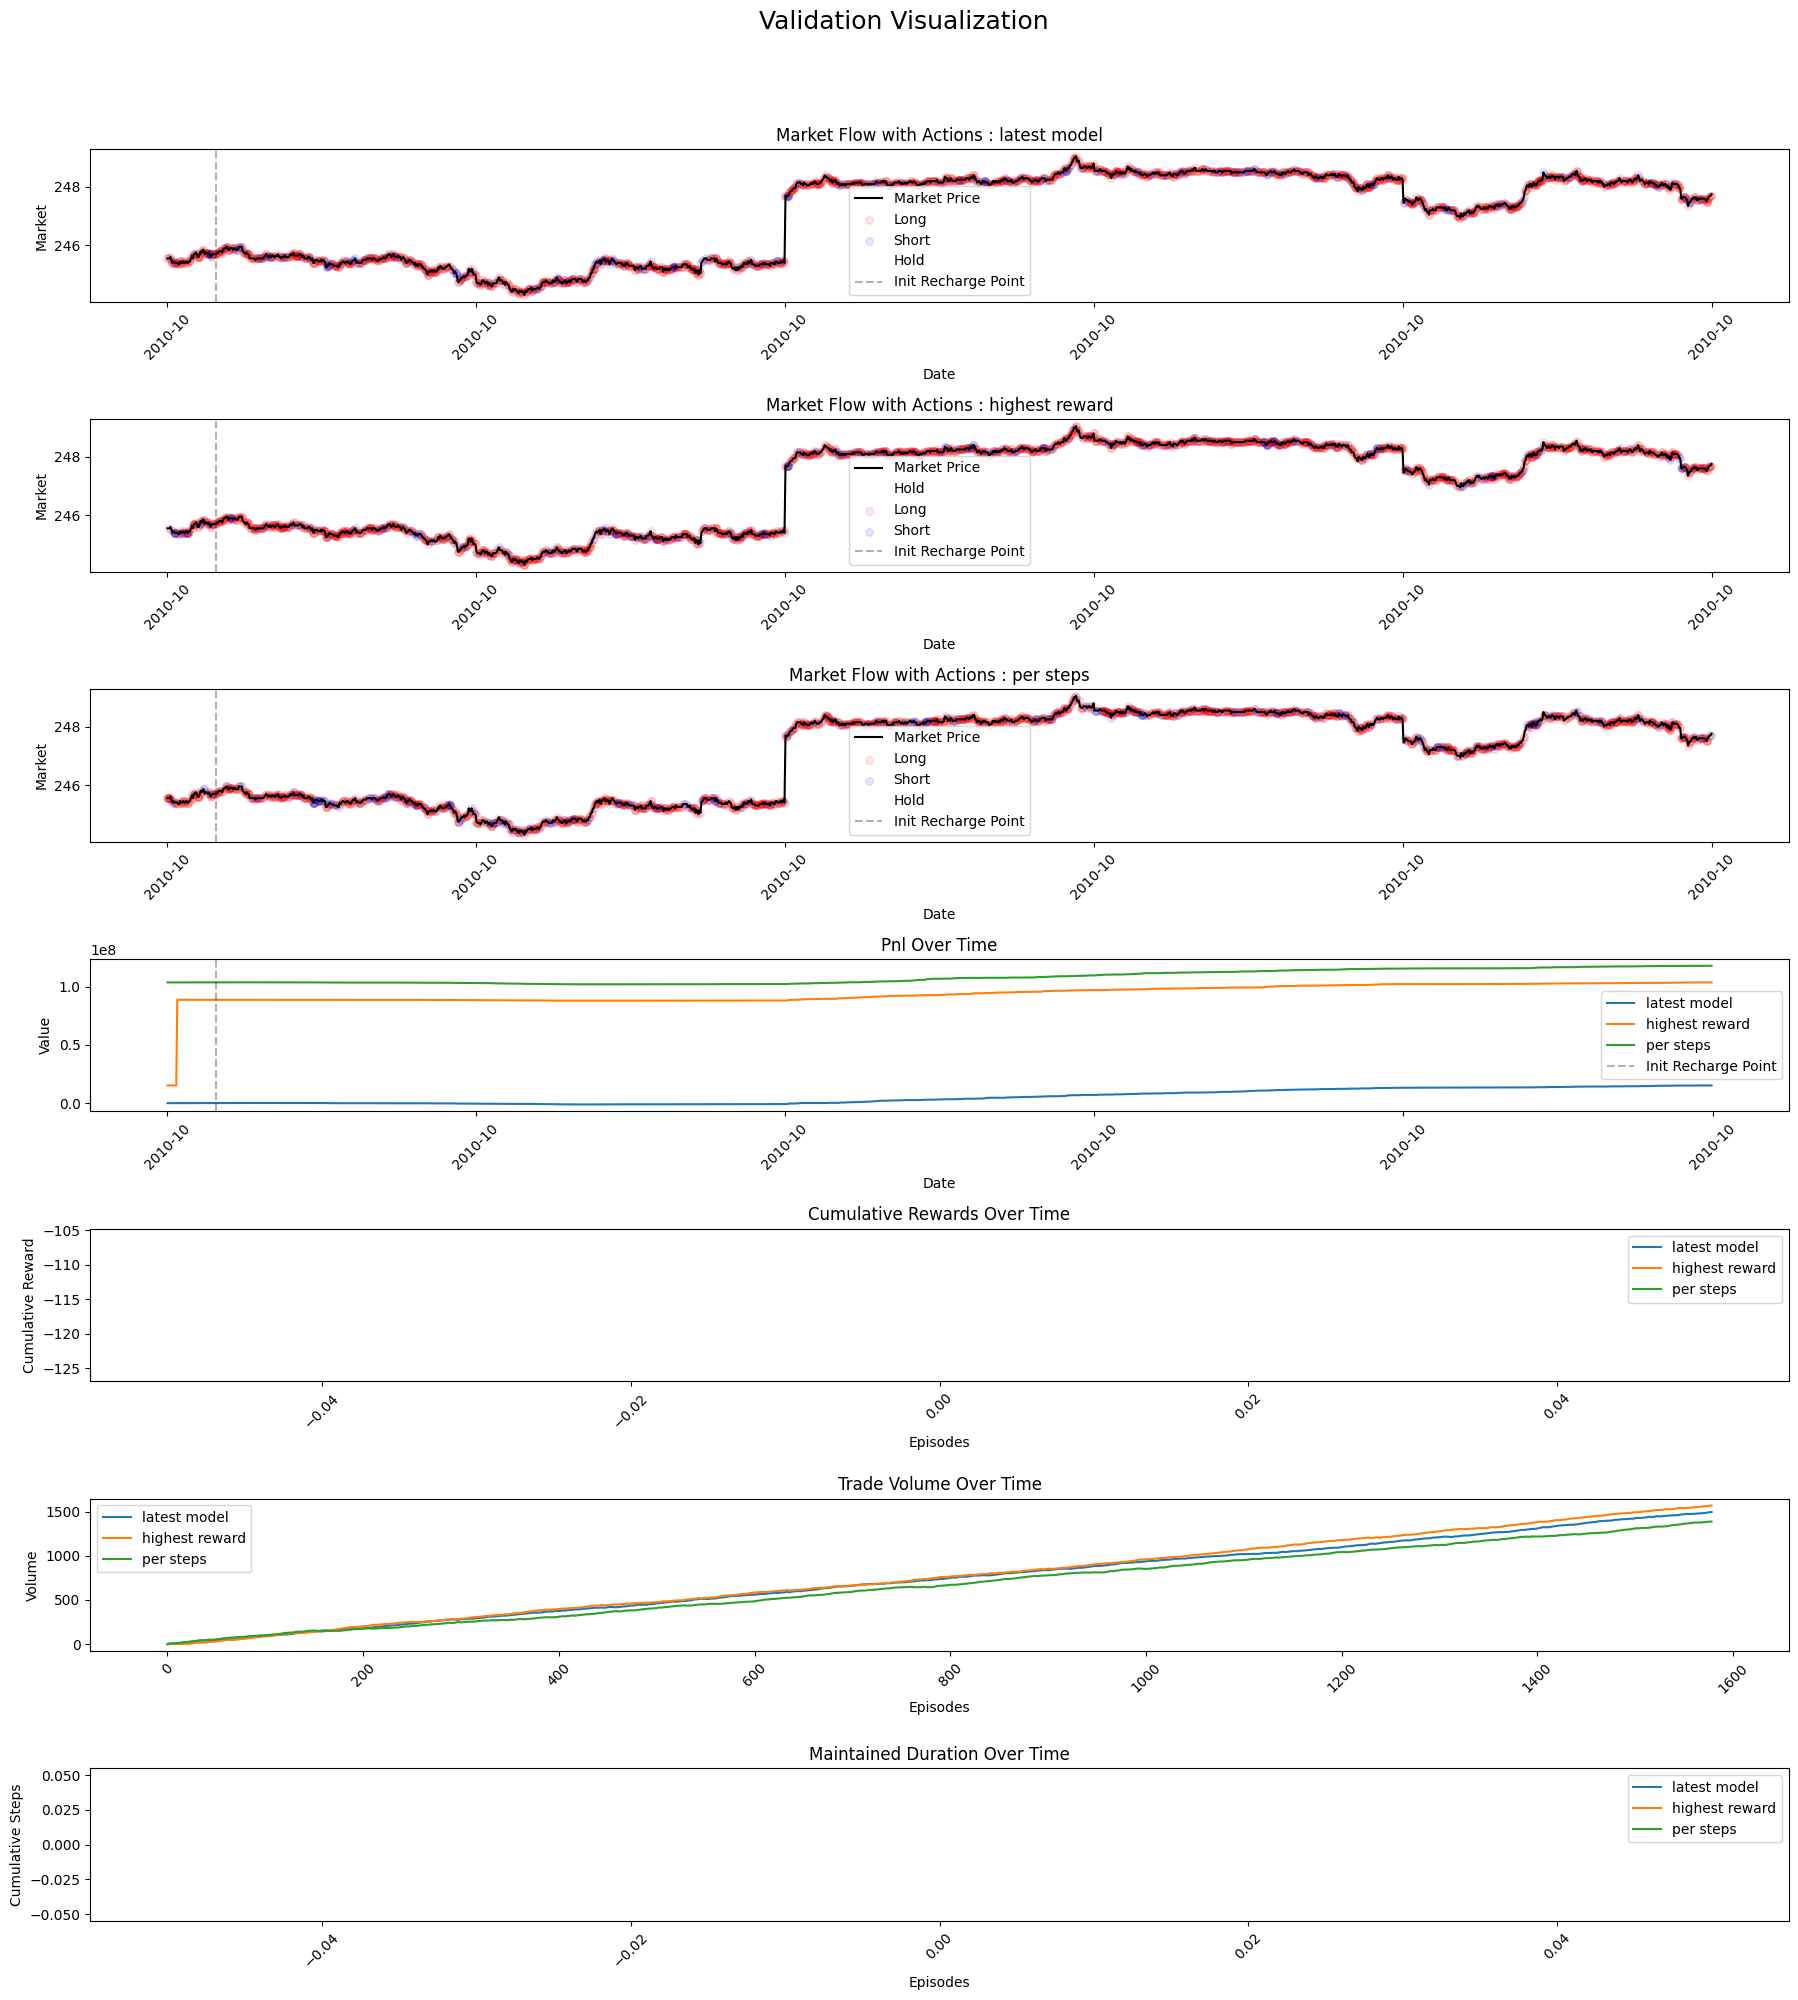

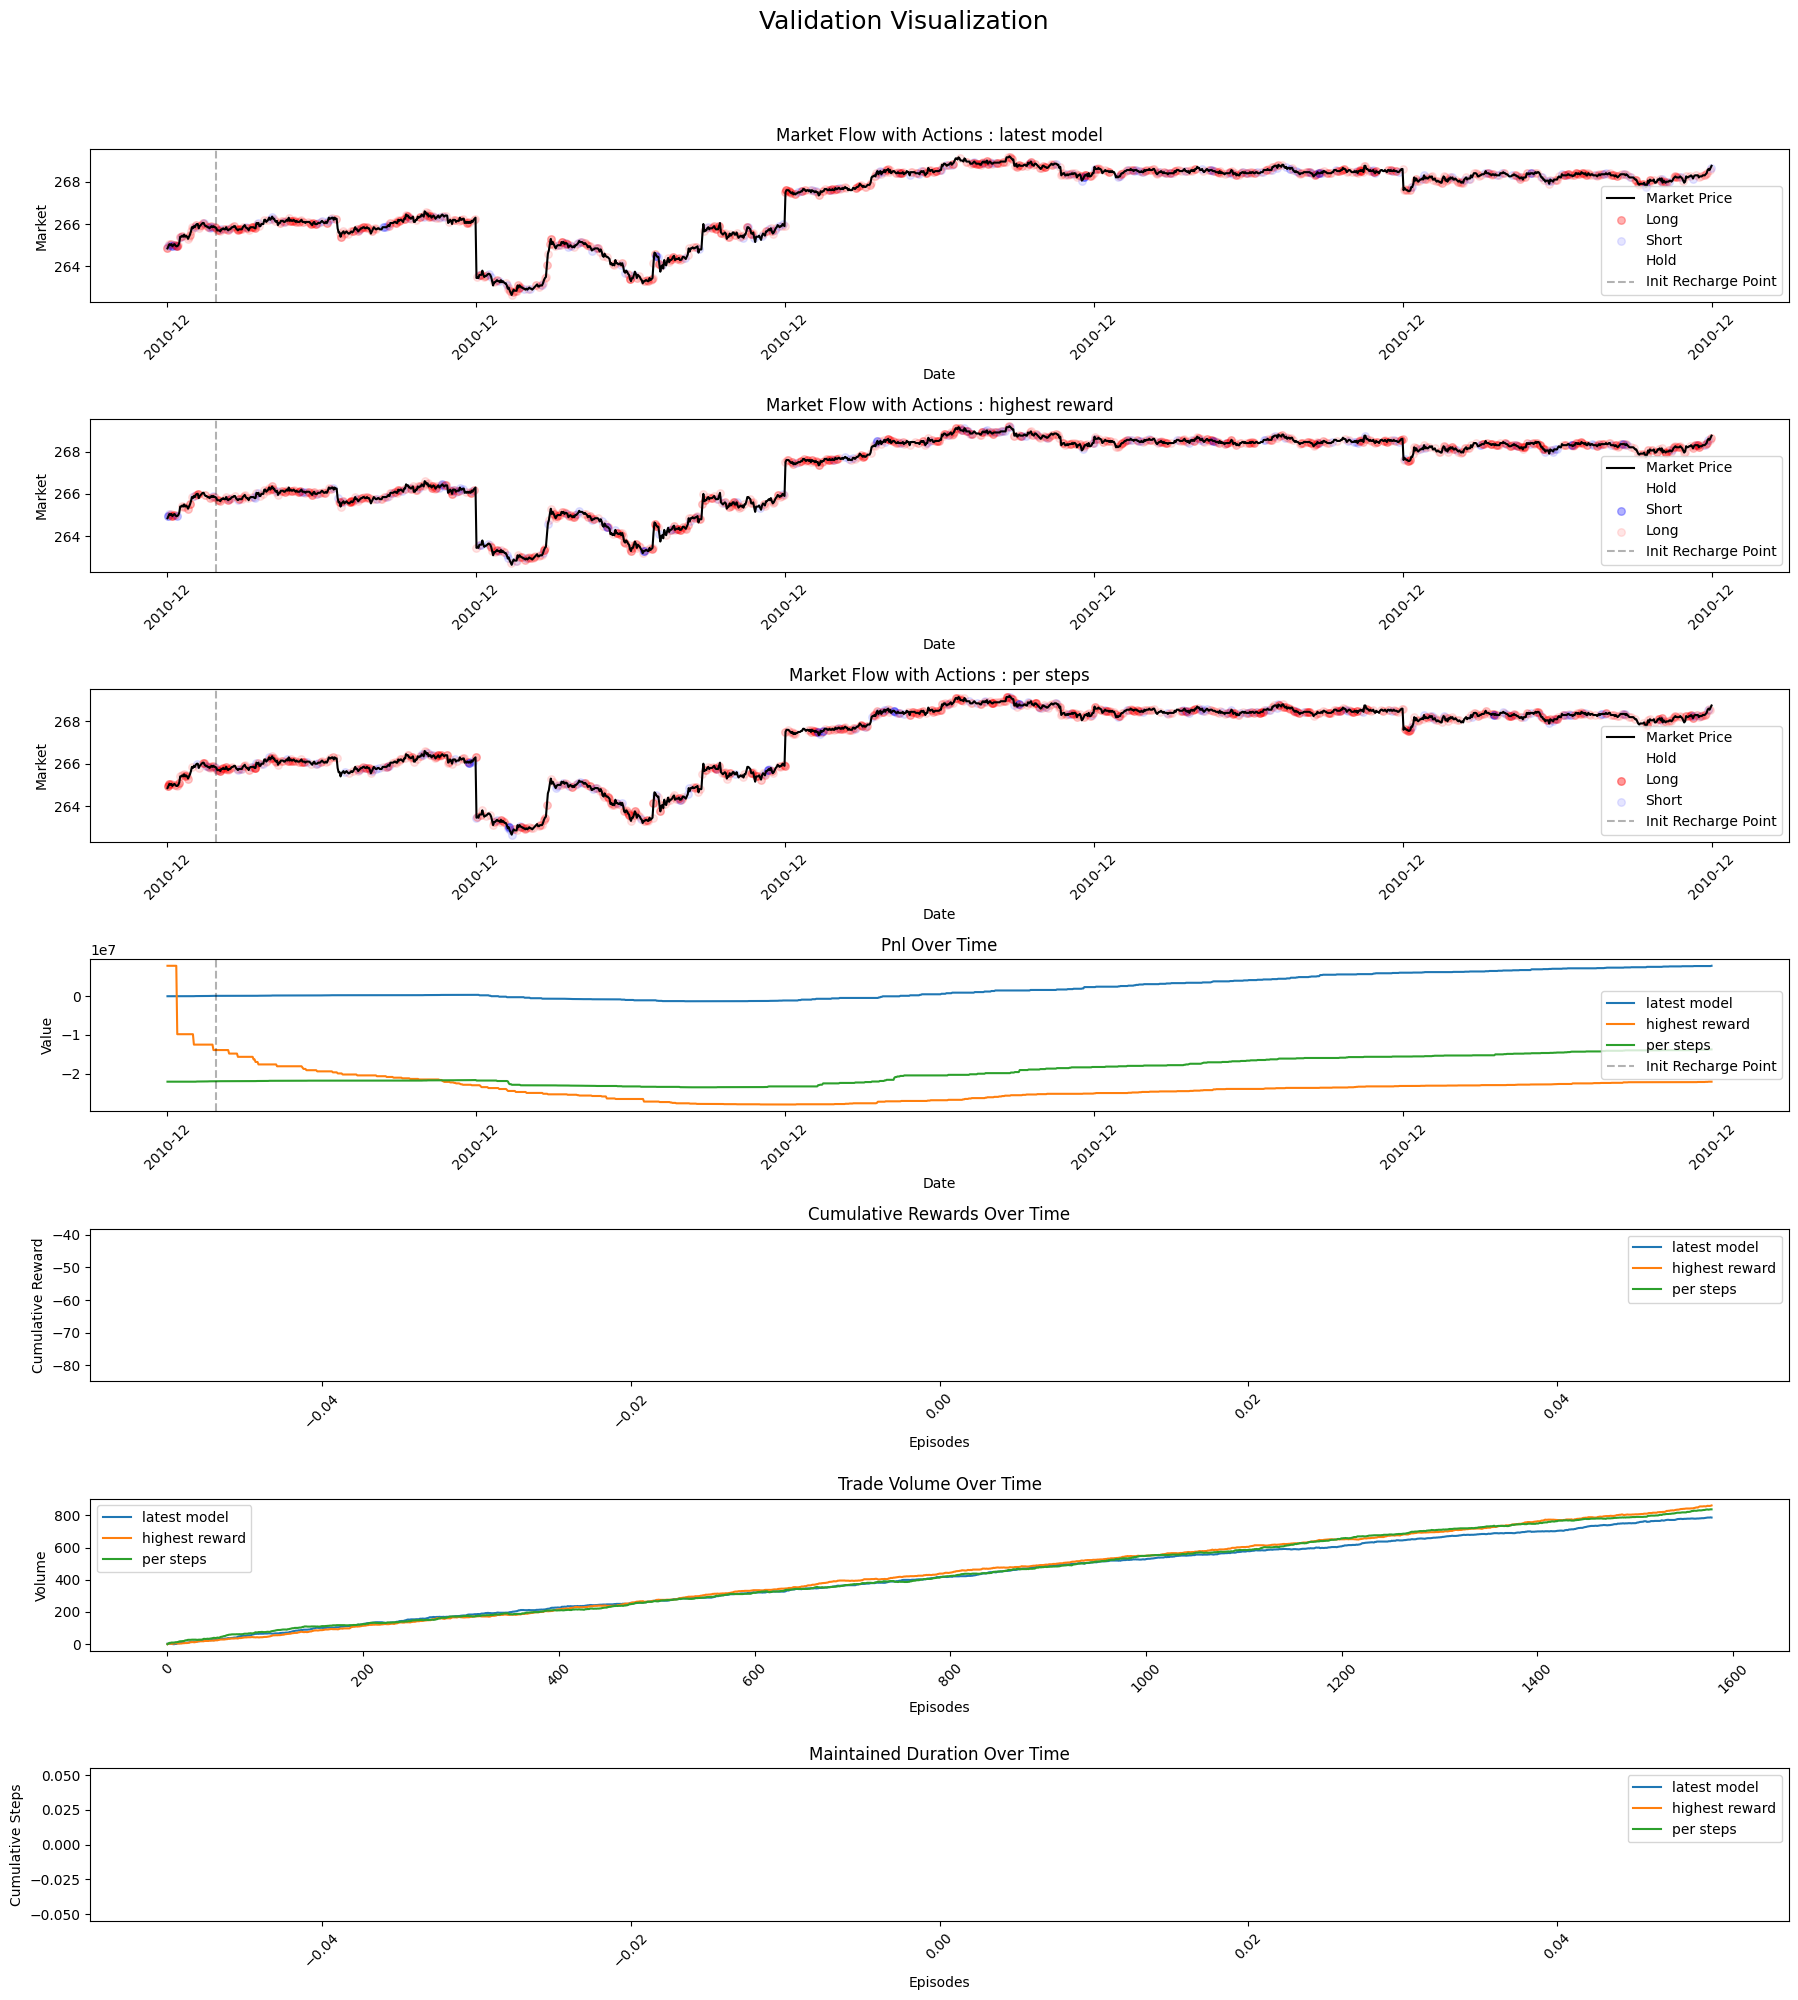

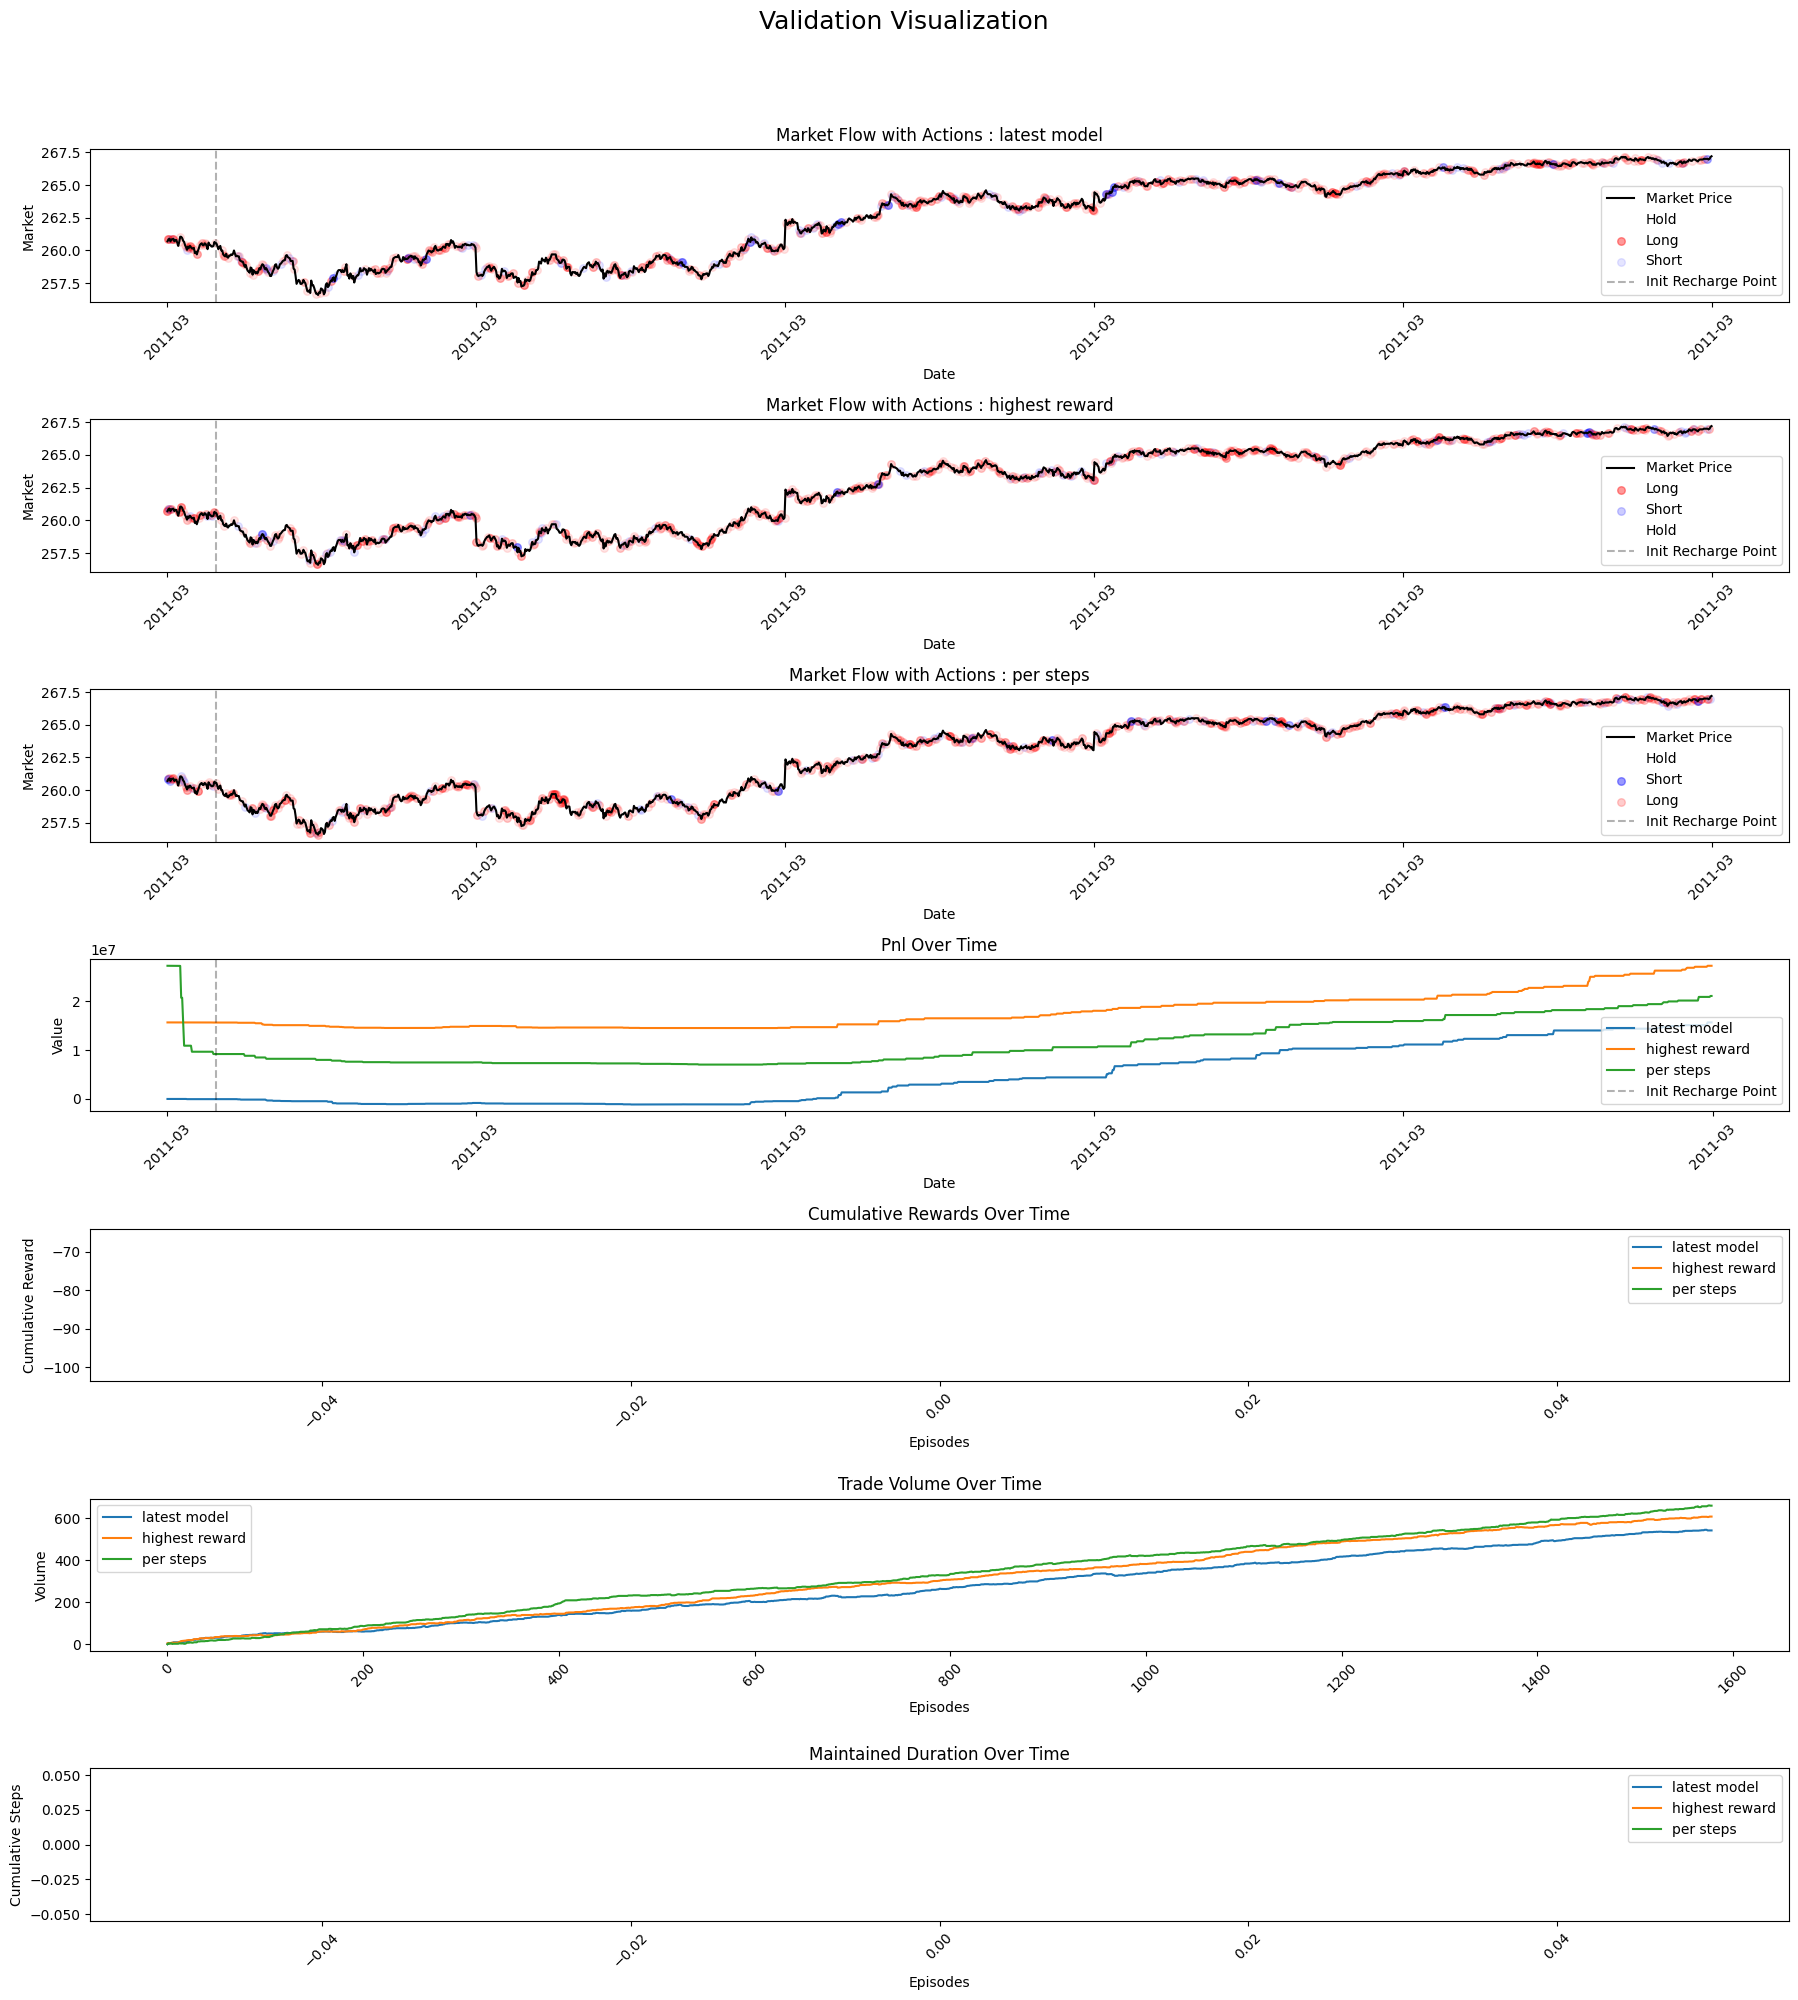

In [8]:
trainer = NonEpisodicTrainer(
    df=df,
    env=FuturesEnvironment,
    train_valid_timestep=CONFIG.TRAIN_VALID_TIMESTEP,
    window_size=CONFIG.WINDOW_SIZE,
    state=state,
    reward_ftn=CONFIG.REWARD_FTN,
    done_ftn=CONFIG.DONE_FTN,
    start_budget=CONFIG.START_BUDGET,
    scaler=CONFIG.SCALER,
    position_cap=CONFIG.POSITION_CAP,
    agent=agent,
    model=model,
    optimizer=optim.Adam,
    device=CONFIG.DEVICE,
    n_steps=CONFIG.N_STEPS,
    ma_interval=CONFIG.MA_INTERVAL,
    save_interval=CONFIG.SAVE_INTERVAL,
    path=CONFIG.PATH
)

trainer()